In [ ]:
%pip install pandas
%pip install numpy
%pip install scipy
%pip install seaborn
%pip install matplotlib
%pip install imblearn
%pip install shap
%pip install xgboost
%pip install scikit-learn

In [146]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('./data/diabetes.csv')
df1 = df.copy()
df.info()


In [148]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [149]:
df.shape

(768, 9)

In [150]:
df.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

For the label 'outcome' and feature 'pregnancies' having value of 0 is normal. E.g a user can stay without being pregnant. However, for the rest(with the exception of age and diabetespedigreefunction, which both don't have 0 values), you can't have 0 values for them. E.g a person can't have a bloodpressue of 0.

This implies missing values or incomplete data, and it has to be dealt with somehow.

In [151]:
df.Glucose.min(), df.Glucose.max(), df.Glucose.median()

(np.int64(0), np.int64(199), np.float64(117.0))

In [152]:
df.Insulin.min(), df.Insulin.max(), df.Insulin.median()

(np.int64(0), np.int64(846), np.float64(30.5))

In [155]:
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns


plotting the distribution of the features and their skewness

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


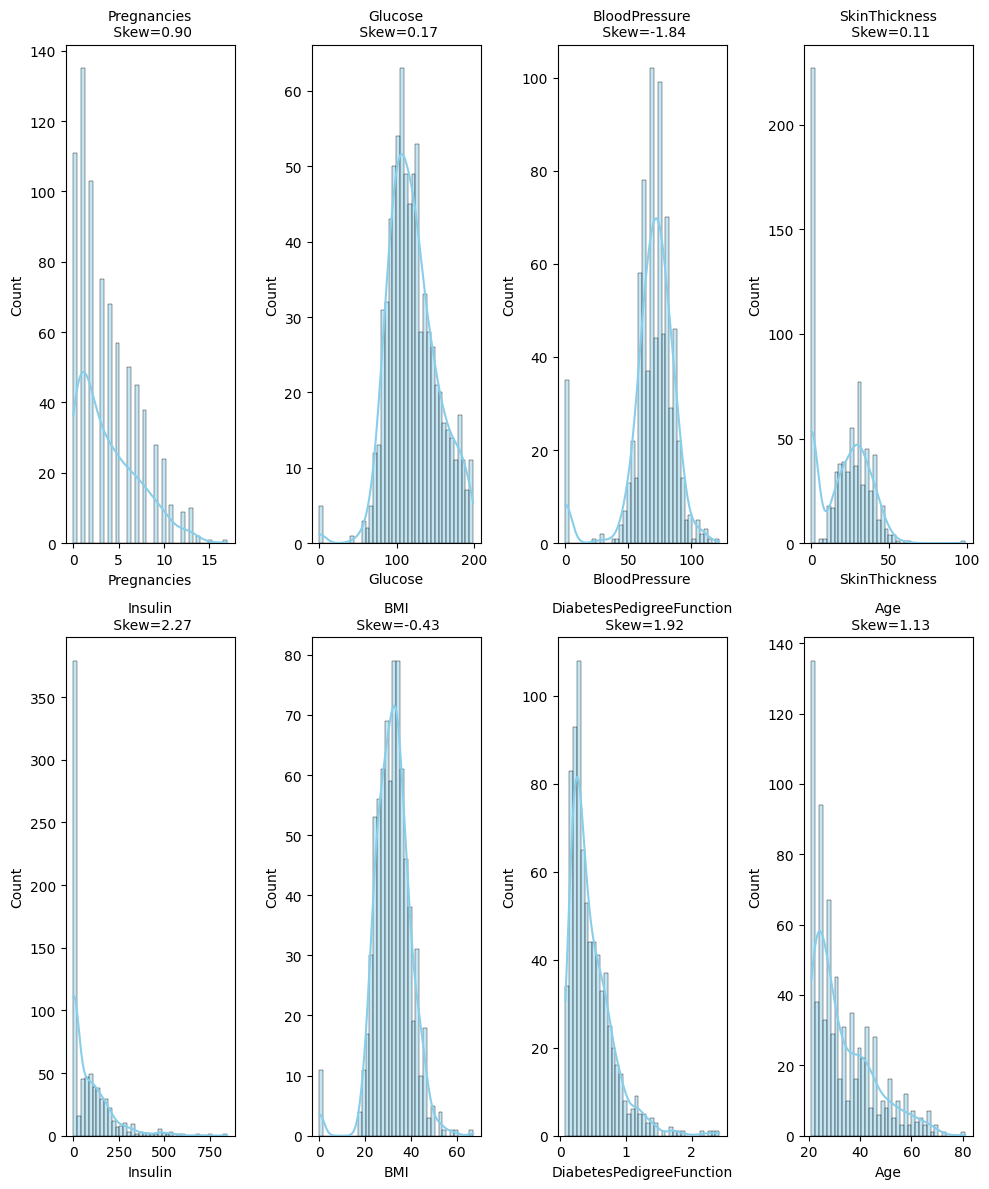

In [156]:

skewness_container = {}

col_length = int(df.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

In [157]:
skewness_sum = {
    'High': [col for col,val in skewness_container.items() if abs(val) >= 1],
    'moderate': [col for col,val in skewness_container.items() if 0.5 <= abs(val) < 1 ],
    'fairly': [col for col,val in skewness_container.items() if abs(val) < 0.5],
}
skewness_sum

{'High': ['BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age'],
 'moderate': ['Pregnancies'],
 'fairly': ['Glucose', 'SkinThickness', 'BMI']}

### IMPUTATION OF ZERO VALUES

From the distribution plot, 'Glucose' and 'BMI' are fairly skewed and also have low zero values; 5 and 11 respectively. So I will use median here - no distortion of distribution.

In [159]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [160]:
df_zero_values = df[['Glucose','BMI','BloodPressure']]
median_imputer = SimpleImputer(strategy='median')
df_zero_values = df_zero_values.replace(0, np.nan)
df_zero_values_imputed = pd.DataFrame(median_imputer.fit_transform(df_zero_values),
                       columns=df_zero_values.columns)

df[['Glucose', 'BMI','BloodPressure']] = df_zero_values_imputed

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


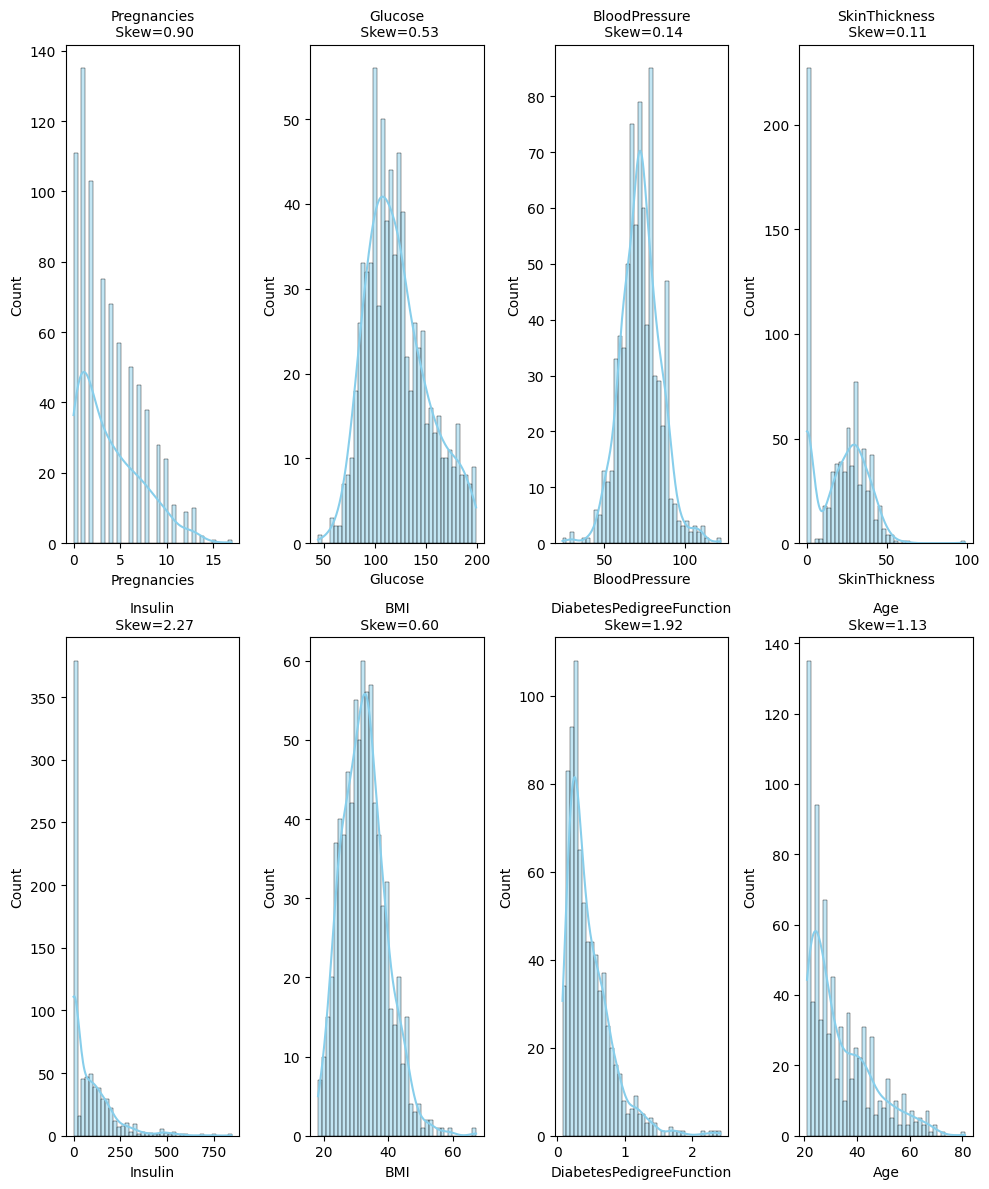

In [161]:

skewness_container = {}

col_length = int(df.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

The skewness of 'Glucose' and 'BMI' looks to be worse, but it does correct the problem of left tailed skewness due to zero values.

I will include the two features in the MICE inputation and compare - this is to check if my assumption of no distortion by using mean in this context is wrong

In [162]:
df1.eq(0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [163]:
features = ['Glucose', 'BMI', 'Insulin', 'SkinThickness', 'BloodPressure']  
df1[features] = df1[features].replace(0, np.nan)



mice_inputer = IterativeImputer(max_iter=10, random_state=111)
imputed = mice_inputer.fit_transform(df1[features])

df1[features] = imputed
df1.eq(0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

0 Pregnancies
1 Glucose
2 BloodPressure
3 SkinThickness
4 Insulin
5 BMI
6 DiabetesPedigreeFunction
7 Age


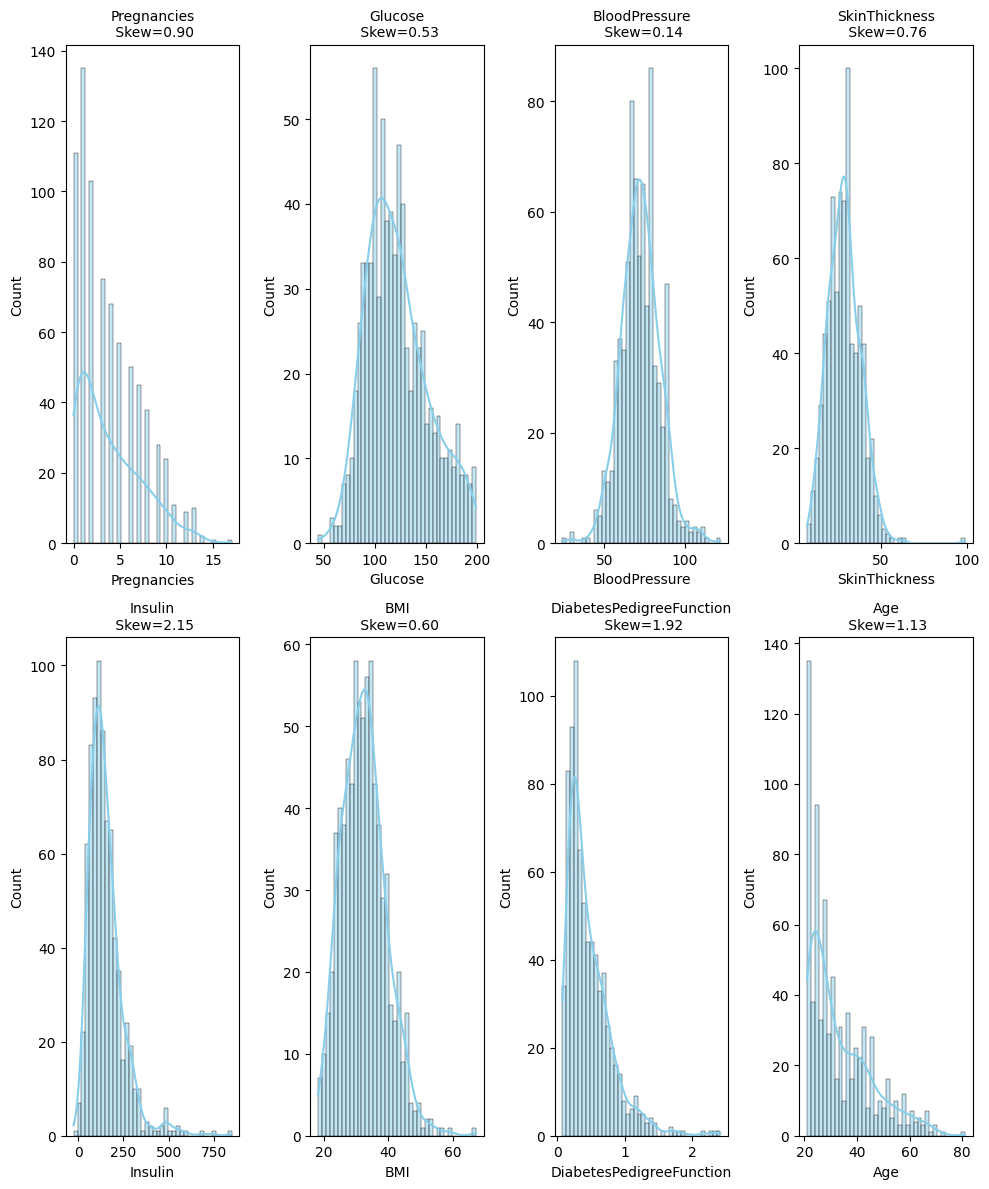

In [164]:
skewness_container = {}

col_length = int(df1.columns.drop('Outcome').shape[0]/2)
fig, axes = plt.subplots(2,col_length, figsize=(10,12))
axes = axes.flatten()

for idx, col in enumerate(df1.columns.drop("Outcome")):
    print(idx, col)
    ax = axes[idx]
    sns.histplot(df1[col], kde=True, bins=40, color='skyblue', ax=ax)
    skewness = skew(df1[col].dropna())
    skewness_container[col] = skewness
    ax.set_title(f'{col}\n Skew={skewness:.2f}', fontsize=10)
plt.tight_layout()
plt.show()

In [165]:
skewness_sum = {
    'High': [col for col,val in skewness_container.items() if abs(val) >= 1],
    'moderate': [col for col,val in skewness_container.items() if 0.5 <= abs(val) < 1 ],
    'fairly': [col for col,val in skewness_container.items() if abs(val) < 0.5],
}
skewness_sum

{'High': ['Insulin', 'DiabetesPedigreeFunction', 'Age'],
 'moderate': ['Pregnancies', 'Glucose', 'SkinThickness', 'BMI'],
 'fairly': ['BloodPressure']}

The same distribution is attained with the MICE imputation

## Next, examination of the correlation between the features

In [166]:
df_corr = df1.corr()
df_corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129652,0.209181,0.087359,0.068747,0.024477,-0.033523,0.544341,0.221898
Glucose,0.129652,1.000000,0.230087,0.242262,0.699920,0.235599,0.138322,0.268470,0.494685
BloodPressure,0.209181,0.230087,1.000000,0.241371,0.134121,0.297206,-0.000148,0.326662,0.176654
SkinThickness,0.087359,0.242262,0.241371,1.000000,0.251856,0.710747,0.124137,0.111028,0.277964
Insulin,0.068747,0.699920,0.134121,0.251856,1.000000,0.280154,0.135984,0.185666,0.360871
BMI,0.024477,0.235599,0.297206,0.710747,0.280154,1.000000,0.151454,0.030689,0.314434
DiabetesPedigreeFunction,-0.033523,0.138322,-0.000148,0.124137,0.135984,0.151454,1.000000,0.033561,0.173844
Age,0.544341,0.268470,0.326662,0.111028,0.185666,0.030689,0.033561,1.000000,0.238356
Outcome,0.221898,0.494685,0.176654,0.277964,0.360871,0.314434,0.173844,0.238356,1.000000


Using visuals, would make the relationship more obvious

C:\Users\User\AppData\Local\Temp\ipykernel_18288\3262004059.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = ax.text(j,i, round(df_corr.iloc[i][j],2), ha='center', va='center', color='w')


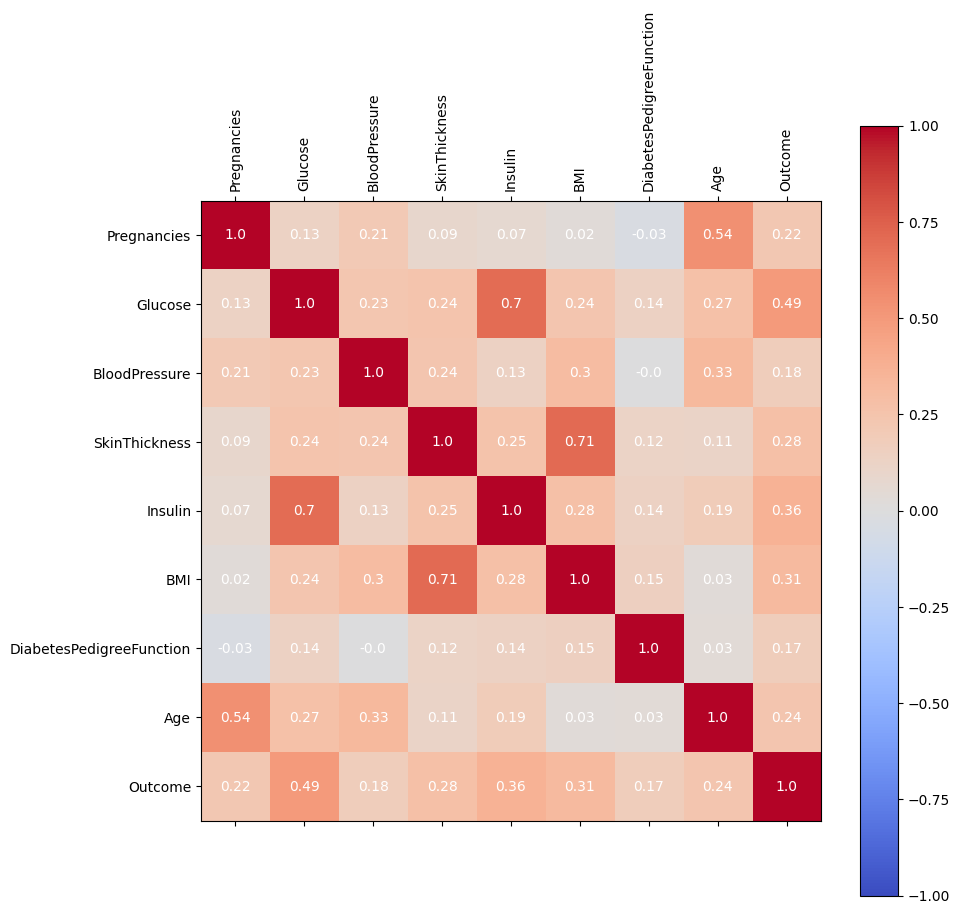

In [167]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(df_corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(df1.columns), 1)
ax.set_xticks(ticks)
ax.set_xticklabels(df1.columns)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(df.columns)
for i in range(df1.shape[1]):
    for j in range(9):
        text = ax.text(j,i, round(df_corr.iloc[i][j],2), ha='center', va='center', color='w')
plt.show()

In [168]:
top_5_corr = df_corr.nlargest(5, 'Outcome')
top_5_corr['Outcome']

Outcome          1.000000
Glucose          0.494685
Insulin          0.360871
BMI              0.314434
SkinThickness    0.277964
Name: Outcome, dtype: float64

Apart from Glucose, Insulin, BMI, SkinThickness have the highest correlation with the Outcome. The rest have very little correlation, so I'm using these 4 for training to establish a bases model

## Model Training

### Logistic Regression

Because of the small number of training data, I'm using fold cold-validation

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In my initial search for a base model, I didn't include 'Age' feature. I added 'Age' after checking feature_importances_ of random forest classifier model. 'Age' has better non-linear  correlation with 'Outcome' than 'SkinThickness'.

In [170]:
result = []
x = df1[['Glucose', 'Insulin', 'BMI', 'SkinThickness', 'Age']]
y = df1.iloc[:,8]

In [171]:
log_regress = LogisticRegression()
log_regress_score = cross_val_score(log_regress, x,y, cv=10, scoring='recall').mean()

result.append(log_regress_score)
log_regress_score

np.float64(0.5747863247863247)

In [172]:
rf_class = RandomForestClassifier()
rf_class_score = cross_val_score(rf_class, x, y, cv=10, scoring='recall').mean()
rf_class_score

np.float64(0.6041310541310543)

### K-Nearest Neighbors

In [173]:
from sklearn.neighbors import KNeighborsClassifier

In [174]:
cv_scores = []
folds = 10

ks = list(range(1, int(len(x) * ((folds-1)/folds)),2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x, y, cv=folds, scoring='recall').mean()
    cv_scores.append(score)

knn_score = max(cv_scores)

best_k = ks[cv_scores.index(knn_score)]

print('Best value for K', best_k)
result.append(knn_score)

Best value for K 11


### Support Vector Machines

In [175]:
from sklearn.svm import SVC

In [176]:
kernels = ['linear', 'rbf']

for kernel in kernels:
    svm_model = SVC(kernel = kernel)
    svm_score = cross_val_score(svm_model, x,y,cv=10,scoring='recall').mean()
    result.append(svm_score)

In [178]:
from xgboost import XGBClassifier

In [179]:
# Quick tuned versions
rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
xgb_tuned = XGBClassifier(n_estimators=100, max_depth=4, scale_pos_weight=(y==0).sum()/(y==1).sum(), random_state=42)

rf_tuned_score = cross_val_score(rf_tuned, x, y, cv=10, scoring='recall').mean()
xgb_tuned_score = cross_val_score(xgb_tuned, x, y, cv=10, scoring='recall').mean()

result.append(rf_tuned_score)
result.append(xgb_tuned_score)

print(f"Tuned RF:   {rf_tuned_score:.4f}")
print(f"Tuned XGB:  {xgb_tuned_score:.4f}")


Tuned RF:   0.7949
Tuned XGB:  0.6534


Random forest performed best

In [180]:
model_columns = ['Log_reg', 'KNN', 'SVM_Linear', 'SVM_rbf', 'RF', 'XG']
df_model_scores = pd.DataFrame(result, index=model_columns)
df_model_scores

,0
Log_reg,0.574786
KNN,0.630769
SVM_Linear,0.559829
SVM_rbf,0.485613
RF,0.794872
XG,0.653419


In [181]:
X = df1.drop(columns='Outcome')
y = df1['Outcome']
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

I will use SMOTE to deal with class imbalance.

In [183]:
from imblearn.over_sampling import SMOTE

In [184]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=100, max_depth=4, class_weight='balanced', random_state=42, criterion='gini'
)

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

print("\n### Random Forest Classifier ###")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


### Random Forest Classifier ###
Accuracy: 0.7800
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.68      0.75        99
           1       0.74      0.88      0.80       101

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200

Confusion Matrix:
 [[67 32]
 [12 89]]


Ensemble model of RF AND XGB

In [194]:
from sklearn.ensemble import VotingClassifier

clf2 = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=4, class_weight='balanced')
clf3 = XGBClassifier( eval_metric='logloss', random_state=42, n_estimators=100)

ensemble = VotingClassifier(
    estimators=[
        ('rf', clf2), ('xgb', clf3)],
    voting='soft'  
)

ensemble_score = cross_val_score(ensemble, X_resampled, y_resampled, cv=10, scoring='recall').mean()
print(f"Ensemble Recall: {ensemble_score:.3f}")


ensemble.fit(X_train, y_train)

y_pred_rf = ensemble.predict(X_test)

print("\n### Random Forest Classifier ###")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Ensemble Recall: 0.836

### Random Forest Classifier ###
Accuracy: 0.7700
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75        99
           1       0.74      0.83      0.79       101

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Confusion Matrix:
 [[70 29]
 [17 84]]


SMOTE with Random Forest alone performed with the recall metric. This is the most important metric for this use case.


### Random Forest Feature Importances ###
Glucose                     0.292127
Insulin                     0.209936
BMI                         0.149680
Age                         0.127924
SkinThickness               0.109162
DiabetesPedigreeFunction    0.051587
Pregnancies                 0.038754
BloodPressure               0.020830
dtype: float64


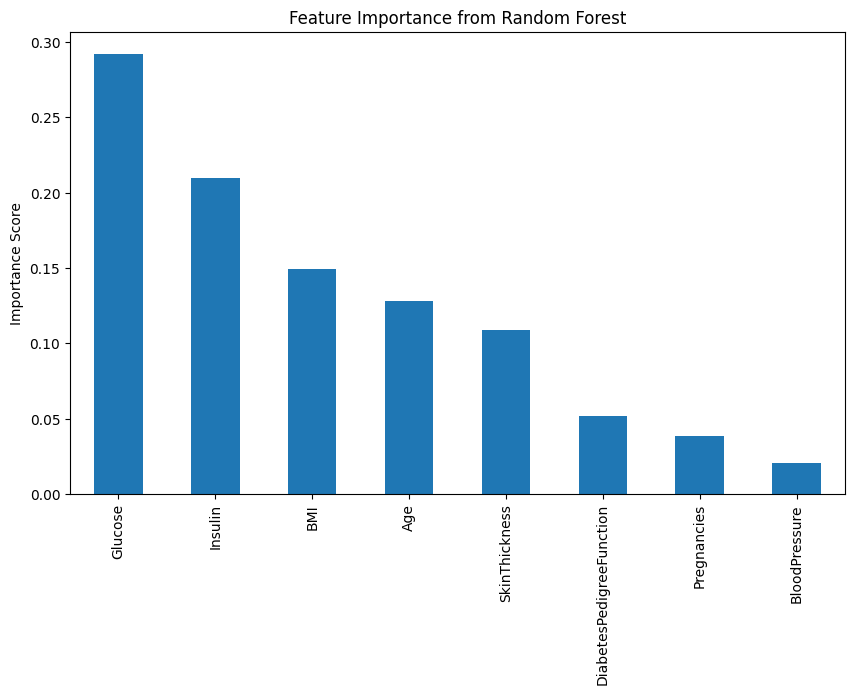

In [187]:
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

print("\n### Random Forest Feature Importances ###")
print(feature_importances.sort_values(ascending=False))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.ylabel('Importance Score')
plt.show()

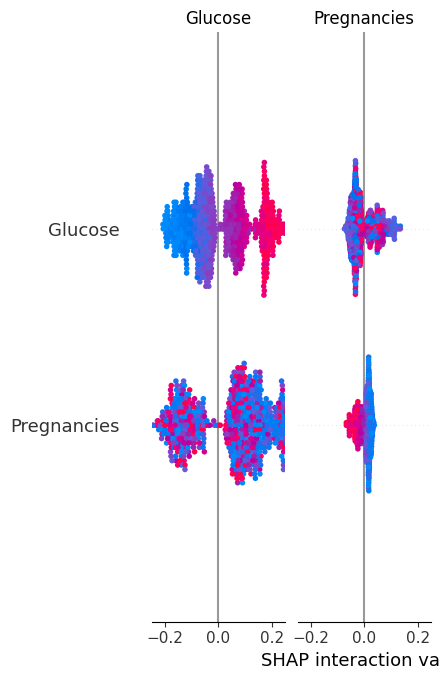

In [188]:
import shap

model = rf_classifier
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)

shap.summary_plot(shap_values, X_resampled)


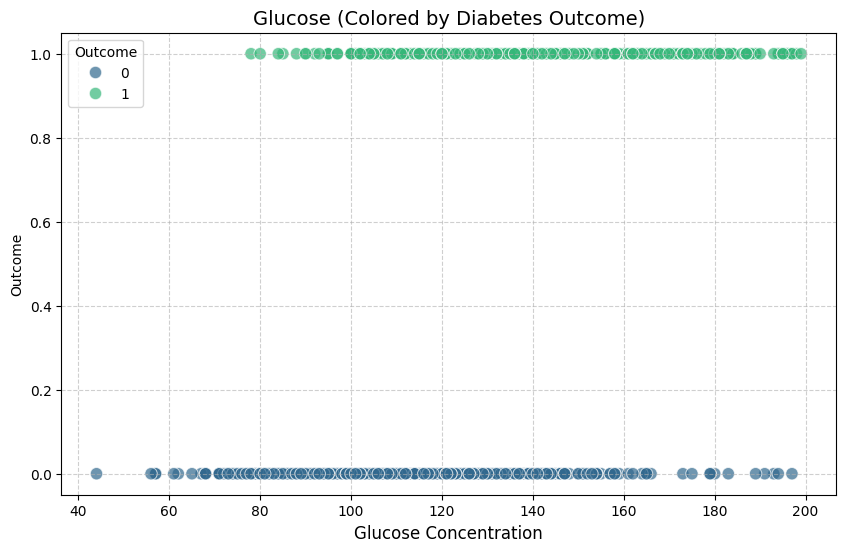

: 

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Glucose',
    y='Outcome',
    hue='Outcome', 
    data=df1,
    palette='viridis', 
    s=80, 
    alpha=0.7 
)

plt.title('Glucose (Colored by Diabetes Outcome)', fontsize=14)
plt.xlabel('Glucose Concentration', fontsize=12)
plt.legend(title='Outcome')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show() 

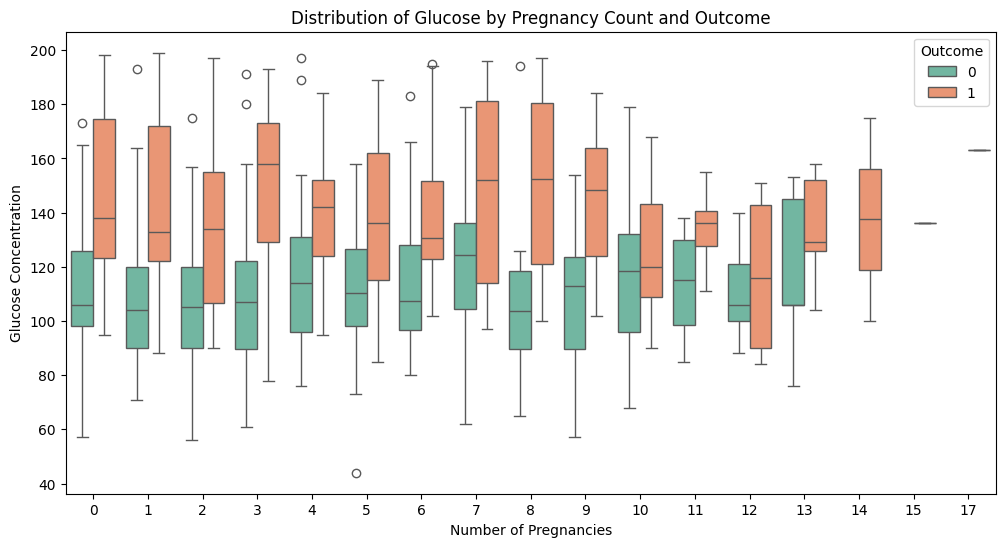

In [189]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Pregnancies', y='Glucose', hue='Outcome', data=df1, palette='Set2')
plt.title('Distribution of Glucose by Pregnancy Count and Outcome')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Glucose Concentration')
plt.show()

The model feature_importances_ provide most important features on the model level.
The SHAP chart shows that on sample level, Glucose and Insulin play the major part in pushing the prediction towards diabetic or not


In [192]:
import pickle 
import os

In [196]:
filename = 'diabetes.sav'
filename = os.path.join('model', filename)
with open(filename, 'wb') as f:
    pickle.dump(rf_classifier, f)

## Deployment Next